# テキストマイニング: ユーザーレビューの分析

## 1. はじめに
### 1.1. 本日のゴール

**「テキストって数字みたいに分析できるのか。」**と一瞬でも感じること。

### 1.2. テキストマイニングとは？

- テキスト（文字）を定量的に分析する手法。具体的には、
 - [形態素解析](https://ledge.ai/morpho_analysis_japan/): 文章を単語レベルに分割する
 - [wordcloud](https://qiita.com/kenmatsu4/items/9b6ac74f831443d29074): 単語の出現頻度を可視化する
 - 共起ネットワーク: 単語間の繋がりを可視化する
   - [KH Coder](https://toukeier.hatenablog.com/entry/2019/08/19/203408)というフリーソフトで作成することも出来るみたい。
   - 共起ネットワークに関してはRの方が簡単に作れます。
 - [word2vec](https://qiita.com/g-k/items/69afa87c73654af49d36)(自然言語処理): 単語をベクトルとして扱えるようにする手法。これを使うと、深層学習モデルにテキストデータを入力出来るようになる。
- マーケティングの文脈だと、ユーザーのレビューデータやSNSの投稿、アンケートの自由記述欄が主な分析対象
 - レビューデータやSNSの投稿はWebスクレイピングやAPIを叩けば簡単に取得できる 

### 1.3. ハンズオンのお題

- みなさんはECサイトでスキーウェアを販売するB社の売り上げ向上プロジェクトにアサインされました。
- 先方は特に子供向けのスキーウェアの売り上げがイマイチ伸びないことを問題視しています。
- みなさんの中で議論をした結果、商品をうまく訴求出来ていないこと（ユーザーが感じているベネフィットと訴求内容のズレ）が1つの仮説として浮かんできました。
- そこで、B社子供向けのスキーウェアを購入したユーザーのレビューを収集し、テキストマイニングでユーザーの声を定量的に評価することにしました。

### 1.4. ハンズオンの構成

2. **[データの前処理](#first-bullet)**
3. **[形態素解析](#second-bullet)**
4. **[テキストの出現頻度の可視化; Wordcloud](#third-bullet)**
5. **[テキストの繋がり; 共起ネットワーク](#fourth-bullet)**

## 2. データの前処理<a class="anchor" id="first-bullet"></a>
### 2.1. 読み込み
いつも通り`pandas`を使っていきます。今回はB社子供用スキーウェアに関する楽天のレビューデータを使います。

- rakuten_review_high.csv
    - 評価が5段階中の4以上をつけているユーザーのレビュー
- rakuten_review_low.csv
    - 評価が5段階中の4未満をつけているユーザーのレビュー
    - ほとんどの商品の平均評価が4点台だったので、サンプル数は少ないです。

In [96]:
import pandas as pd

In [97]:
df_low = pd.read_csv("rakuten_review_low.csv", header = None)
df_low.head()

,0
0,120センチ前半の子にサイズ130を購入しました。\nあまりにもダボダボしてるのは嫌なので説...
1,１３５センチ、３３キロの娘に。\n大きくて、調整ヒモ最後まで絞っても、引きずってしまいました...
2,デザイン・防水・着こゴチお勧めです。サイズは大きめ！
3,スノボ用だからなのかダボダボで、子供が来にくいといって嫌々きました。自分できれない子供には来...
4,娘に購入しました。とっても気に入りました。サイズですが、上は丁度よかったのですが、下は幅広く...


In [98]:
df_high = pd.read_csv("rakuten_review_high.csv", header = None)
df_high.head()

,0
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...
1,安く買えて良かったです。\n身長140センチで150サイズ買いましたが、裾の調整で問題なさそ...
2,143センチの息子に150を購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題...
3,色、柄とも豊富で、どれもステキです。\n145cmですが150cmのサイズで\n大きいかな…...
4,注文してからすぐに届きました！\n商品もかっこ良くて気に入りました！\nまだ実際に使用してい...


改行が`\n`という文字列として認識されてしまいました。消しましょう。コードを書く時には、消すというより無に置換するといった書き方をします。

- この置換をやってくれるのが`str.replace()`という関数です。（今回はDataFrameのある1列に対して実行するので、`str.replace()`を使います。ベクトルに対して置換をする時は`replace`で出来ます。）
- 参考サイト
    - [pandasの文字列メソッドで置換や空白削除などの処理を行う](https://note.nkmk.me/python-pandas-str-replace-strip-etc/)
    - [Pythonで文字列を置換（replace, translate, re.sub, re.subn）](https://note.nkmk.me/python-str-replace-translate-re-sub/)

In [99]:
df_high[0] = df_high[0].str.replace('\n', '')
df_high.head()

,0
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...
1,安く買えて良かったです。身長140センチで150サイズ買いましたが、裾の調整で問題なさそうです。
2,143センチの息子に150を購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題...
3,色、柄とも豊富で、どれもステキです。145cmですが150cmのサイズで大きいかな…って感じ...
4,注文してからすぐに届きました！商品もかっこ良くて気に入りました！まだ実際に使用していないので...


## 3. 形態素解析<a class="anchor" id="second-bullet"></a>

- 文章を単語レベルに区切る操作が形態素解析です。
- 形態素解析のライブラリとして、Mecabやjanomeがあります。
 - Mecabの方が新しい単語にも対応している。（「インスタ映え」とか。）その一方で、設定が少しめんどくさい。
 - 今回はjanomeを使ってみます。
- 参考資料
 - [janomeの基本的な使い方](https://note.nkmk.me/python-janome-tutorial/)

### 3.1. janomeの基本的な使い方
anaconda環境の人もローカルPCに環境構築している人もターミナルで`pip install janome`を実行して、`janome`パッケージをインストールしましょう。

In [100]:
from janome.tokenizer import Tokenizer

#### 3.1.1. 単語に分割
例として、『本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。』を単語レベルに分割してみます。（インスタンスと呼ばれる）`Tokenizer()`の中にある`tokenize()`という関数を使うと、単語レベルに分割してくれます。

In [101]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

In [102]:
result

<generator object Tokenizer.__tokenize_stream at 0x1346cf190>

結果を見る時には`print()`を使います。

In [103]:
for token in result:
    print(token)

本日	名詞,副詞可能,*,*,*,*,本日,ホンジツ,ホンジツ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
データ	名詞,一般,*,*,*,*,データ,データ,データ
サイエンス	名詞,一般,*,*,*,*,サイエンス,サイエンス,サイエンス
×	記号,一般,*,*,*,*,×,カケル,カケル
マーケティング	名詞,一般,*,*,*,*,マーケティング,マーケティング,マーケティング
勉強	名詞,サ変接続,*,*,*,*,勉強,ベンキョウ,ベンキョー
会	名詞,接尾,一般,*,*,*,会,カイ,カイ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
参加	名詞,サ変接続,*,*,*,*,参加,サンカ,サンカ
し	動詞,自立,*,*,サ変・スル,連用形,する,シ,シ
て	助詞,接続助詞,*,*,*,*,て,テ,テ
いただき	動詞,非自立,*,*,五段・カ行イ音便,連用形,いただく,イタダキ,イタダキ
、	記号,読点,*,*,*,*,、,、,、
ありがとう	感動詞,*,*,*,*,*,ありがとう,アリガトウ,アリガトー
ござい	助動詞,*,*,*,五段・ラ行特殊,連用形,ござる,ゴザイ,ゴザイ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
。	記号,句点,*,*,*,*,。,。,。


In [104]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

list(result)

これら`<janome.tokenizer.Token at ...>`に分割した単語の情報が格納されています。それぞれに関してみていくために、for構文で`print()`させました。

#### 3.1.2. 表層型と基本形

- 表層形: データの中で使われているそのままの形
    - 単語レベルに分割した後に、`.surface`を使うことで、取り出せます
- 基本形: 活用してない形。動詞でいうところの終止形？
    - `.base_form`で取り出せます。

In [105]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

print("表層形"+ "|" +"基本形")
print("==================================")

for token in result:
    print(token.surface + "|" + token.base_form)

表層形|基本形
本日|本日
は|は
データ|データ
サイエンス|サイエンス
×|×
マーケティング|マーケティング
勉強|勉強
会|会
に|に
参加|参加
し|する
て|て
いただき|いただく
、|、
ありがとう|ありがとう
ござい|ござる
ます|ます
。|。


#### 3.1.3. 品詞

- `part_of_speech`で単語の品詞を取り出すことが出来ます。
    - 品詞,品詞細分類1,品詞細分類2,品詞細分類3の順で出力されます。
- `.split()`関数を使うことで()内で指定した文字で分割することが出来ます。
    - 詳しくは[こちら](https://note.nkmk.me/python-split-rsplit-splitlines-re/)を参考にどうぞ

In [106]:
t = Tokenizer()
text = '本日'
result = t.tokenize(text)

for token in result:
    pos = token.part_of_speech
    #pos = token.part_of_speech.split(',')

In [107]:
pos

'名詞,副詞可能,*,*'

In [108]:
pos[0]

'名'

#### 3.1.4. 特定の品詞の文字列を抽出する

In [109]:
t = Tokenizer()
text = '本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'
result = t.tokenize(text)

# 特定の品詞を保存しておく箱（リスト）
words = []

for token in result:
    #品詞を抽出
    pos = token.part_of_speech.split(',')[0]
    
    # もし品詞が名詞だったら、追加する
    if pos == '名詞':
        words.append(token.base_form)

In [110]:
words

['本日', 'データ', 'サイエンス', 'マーケティング', '勉強', '会', '参加']

- `append()`関数を使うことで、箱（リスト）に要素を加えることが出来ます
- リストに関する操作は[このサイト](https://note.nkmk.me/python-list-append-extend-insert/)にまとまっています。

In [111]:
# 例えば、、
name = ["Tomoya", "Kazuma"]
name.append("Kazuki")
name

['Tomoya', 'Kazuma', 'Kazuki']

### 3.2. レビューデータを形態素解析にかけてみる
#### 3.2.1. データを変形
注意すべき点としては、データフレームから1つの文字列（今までの話だと、'本日はデータサイエンス×マーケティング勉強会に参加していただき、ありがとうございます。'）へと変形しなくてはいけないことです。2段階のステップを踏みます。

1. Series（データフレームの1列）をリストにする
    - `.values.tolist()`関数
2. リストを1つの文字列にする
    - `join()`関数。()内で間に挿入する文字列を指定することが出来る。

In [112]:
list_high = df_high[0].values.tolist()

In [113]:
list_test = ','.join(list_high)

#### 3.2.2. 単語レベルに分割

In [114]:
t = Tokenizer()
text = list_test
result = t.tokenize(text)

count = 0

# 最初の10単語だけ出力
for token in result:
    print(token)
    
    count += 1
    
    if count == 10:
        break

身長	名詞,一般,*,*,*,*,身長,シンチョウ,シンチョー
107	名詞,数,*,*,*,*,107,*,*
センチ	名詞,接尾,助数詞,*,*,*,センチ,センチ,センチ
、	記号,読点,*,*,*,*,、,、,、
体重	名詞,一般,*,*,*,*,体重,タイジュウ,タイジュー
18	名詞,数,*,*,*,*,18,*,*
キロ	名詞,接尾,助数詞,*,*,*,キロ,キロ,キロ
、	記号,読点,*,*,*,*,、,、,、
5	名詞,数,*,*,*,*,5,*,*
歳	名詞,接尾,助数詞,*,*,*,歳,サイ,サイ


#### 3.2.3. 特定の品詞だけを抽出

In [115]:
t = Tokenizer()
text = list_test
result = t.tokenize(text)

words = []

for token in result:
    #品詞から名詞だけ抽出
    pos = token.part_of_speech.split(',')[0]
    
    if pos == '名詞':
        words.append(token.base_form)

In [116]:
#初めから10個をみてみます。
words[0:10]

['身長', '107', 'センチ', '体重', '18', 'キロ', '5', '歳', '男児', '用']

## 4. テキストの出現頻度の可視化; Wordcloud<a class="anchor" id="third-bullet"></a>
### 4.1. word cloud の基本
Anaconda環境の人はAnaconda promptで`conda install -c conda-forge wordcloud`を実行してください。

In [117]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [118]:
# リストを文字列に変換
word_chain = ','.join(words)

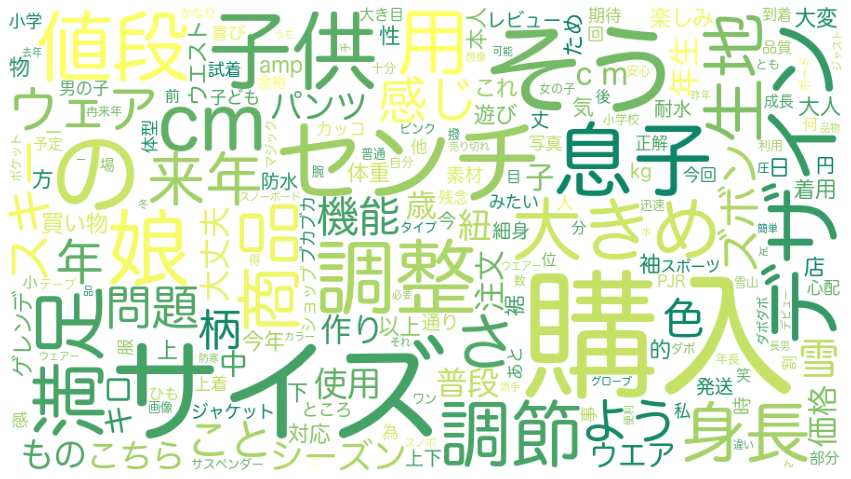

In [119]:
# ワードクラウド作成
W_123 = WordCloud(width = 900, height = 500, background_color='white', colormap='summer', collocations=False,font_path='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc').generate(word_chain)

plt.figure(figsize=(15,12))
plt.imshow(W_123)
plt.axis('off')
plt.show()

- background_colorで背景色、colormapで文字の色を指定出来ます
    - colormapに関しては[こちら](https://karupoimou.hatenablog.com/entry/2019/05/17/153207)から色々選べます
- collocationで複合語の処理が可能です。これを指定しないと、同じ単語が2回出てくることがあります
    - 詳しくは[こちら](https://qiita.com/kbs/items/33b3dd6dae15f7b20b9e)
- よくみると、入っていて当たり前な単語がありますね。これらを除くことも簡単に出来ます。
    - stopwordsとして指定します。

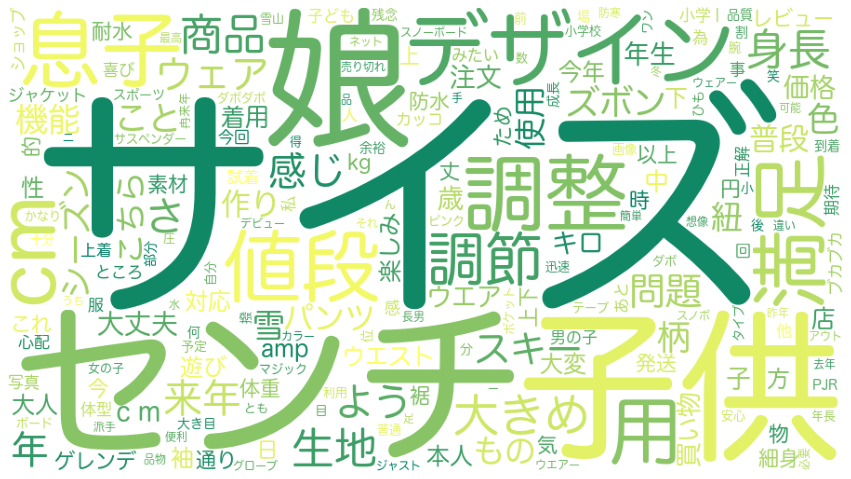

In [120]:
stop_word = [u'の', u'購入', u'そう']

# ワードクラウド作成
W_123 = WordCloud(width = 900, height = 500, 
                  background_color='white', colormap='summer', 
                  collocations=False,
                  font_path='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', 
                  stopwords=set(stop_word)).generate(word_chain)

plt.figure(figsize=(15,12))
plt.imshow(W_123)
plt.axis('off')
plt.show()

### 4.2. より簡単に分析出来るようにする
#### 4.2.1. 関数化

ここまでの処理を関数にします。data, part_of_speech, stop_wordsの3つを入力すると、自動的にwordcloudが出力されるようにしています。

- data: inputになるデータ,文字列の形でないとエラーでます。
- part_of_speech: 抽出したい品詞を指定します。
- stop_words: word_cloudで省きたい言葉を指定します。

In [121]:
def make_word_cloud(data, part_of_speech, stop_words):
    
    # split 
    t = Tokenizer()
    text = data
    result = t.tokenize(text)
    words = []
    
    if part_of_speech == "all":
        for token in result:
            words.append(token.base_form)
    
    else:
        for token in result:
            pos = token.part_of_speech.split(',')[0]
            
            if pos in part_of_speech:
                words.append(token.base_form)
    
    # make word cloud
    word_chain = ' '.join(words)
    
    W_123 = WordCloud(width = 900, height = 500, background_color='white', colormap='summer', 
                      collocations=False,font_path='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', 
                      stopwords=set(stop_words)).generate(word_chain)
    
    plt.figure(figsize=(15,12))
    plt.imshow(W_123)
    plt.axis('off')
    plt.show()

関数の挙動をチェック

他のテキストにもやってみる

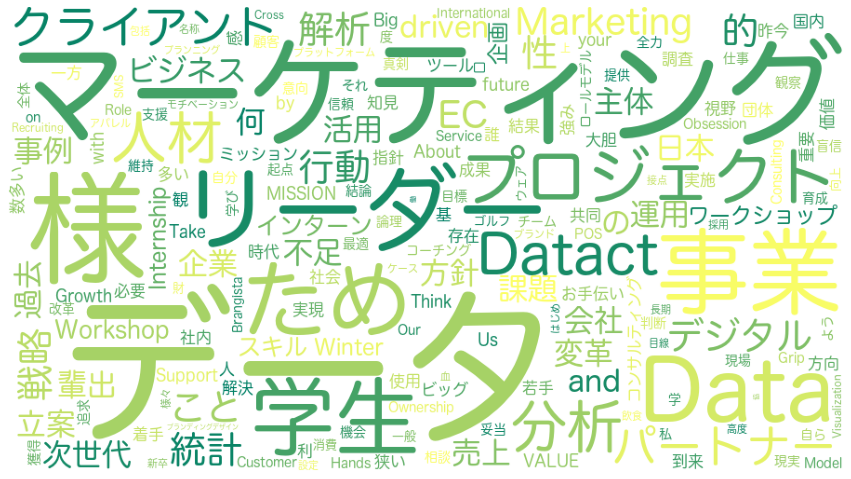

In [122]:
# DatactのHPのテキスト
data = "Growth with Data Marketing Support your future driven by data. About Us Datactは学生主体のマーケティングコンサルティング団体です 統計ツールを使用したビッグデータ解析を基に、マーケティング調査・戦略立案を行っています MISSION この会社は何を成すために 存在しているのか 「日本を変革する人材を輩出する」 デジタルビジネス時代の到来により、データ活用の重要性が叫ばれる昨今。誰もがその必要性を感じる一方で、社内における人材不足や知見不足からその課題感に着手できていない企業様もまだまだ多いと感じております。 Datactはデータ分析やデータマーケティングに強みを持つ若手社会人/学生が主体となり、クライアント様の抱える事業課題をデータ利活用を通じて解決し事業を伸ばすお手伝いをさせて頂くとともに、こうした共同プロジェクトを国内で数多く実施することでデータ人材を増やし、日本を変革する次世代人材の輩出を目指しています。 VALUE ミッションを実現するための 価値観及び行動指針 01 Think Big 狭い視野で考えてしまうと大きな結果を得ることはできません。リーダーは大胆な方針と方向性をつくり、示すことによって成果を導きます。 02 Take Ownership リーダーは自分のチームだけでなく、会社全体のために行動します。リーダーは「それは私の仕事ではありません」とは決して口にしません。 03 Role Model リーダーは常にロールモデルとして自ら学び機会を追求し続けるだけでなく、次世代を育成し、コーチングにも真剣に取り組みます。 04 Data-driven and Hands-on リーダーは常にデータに基いて判断します・ただしデータを盲信するのではなく現場をつぶさに観察し、現実と照らし合わせながら論理的に最も妥当だと思われる結論を導き出します。 05 Customer Obsession リーダーは常にパートナーを起点に考え行動します。パートナーから信頼を獲得し、維持していくために全力を尽くします。 Our Service Datactは統計解析やデータ分析に基づくマーケティング戦略立案、デジタルマーケティング運用を行い、 パートナー様のデジタル改革を支援します 1. Data Marketing Consulting クライアント様の顧客データ、POSデータ、売上データなどのマーケティングデータを統計学的に解析し、データに基づいた最適のマーケティング戦略を提供します。 Datact はクライアント様の意向に添えるように、ビジネス・マーケティング方針について何度もご相談させていただき、目標に向かってパートナーとして共に歩んでいきます。 【過去のプロジェクト事例】Grip International様とのゴルフウェアECでの売上向上プロジェクト、Brangista様との一般消費財 ECプラットフォーム上でのマーケティングプロジェクト。 2. Workshop and Recruiting データ分析、マーケティングといった高度なスキルを持った学生との接点を持ち、クライアント様の長期インターンや新卒採用へつなげるためのワークショップ企画を行います。学生目線で、スキルのある学生にとってモチベーションとなるケース設定を行い、企業様の生データを盛り込んだ血の通ったインターン・ワークショップを企画運用いたします。 【過去のプロジェクト事例】Cross Marketing様 Winter Internship, SMS様 Winter Internship(仮名称), Data Visualization Workshop 飲食事業、アパレルブランド事業、EC事業などをはじめとする様々な事業にて包括的なデータ分析、マーケティングプランニング、ブランディングデザインを協働させて頂いております"
part_of_speech_test = ["名詞", "形容詞"]
stop_words_test = []

make_word_cloud(data, part_of_speech_test, stop_words_test)

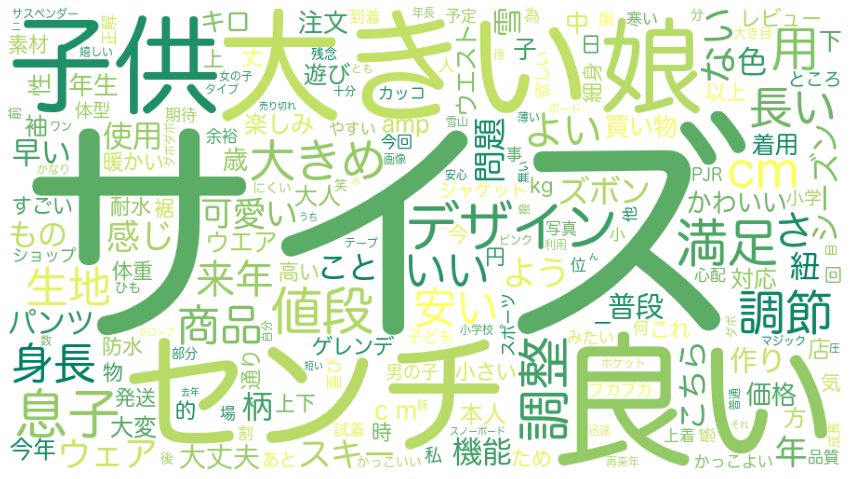

In [123]:
list_series = df_high[0].values.tolist()
data = ','.join(list_series)
part_of_speech_test = ["名詞", "形容詞"]
stop_words_test = [ u'の',u'購入', u'そう']

make_word_cloud(data, part_of_speech_test, stop_words_test)

#### 4.2.2. データを絞る
「サイズ」がよく出てくるみたいです。どういう文脈で「サイズ」が使われているのでしょうか？「サイズ」を含むレビューに関してもう一度wordcloudを作ってみます。

1. 「サイズ」を含むかどうかを判別する列を作る
2. 作成した列をもとにデータを絞る
    - `query()`関数が便利です。詳しくは[こちら](https://note.nkmk.me/python-pandas-query/)。

In [124]:
df_high["flag"] = 0

for i in range(len(df_high.index)):
    
    # サイズが含まれていたらflag = 1になるようにする
    if "サイズ" in df_high.iloc[i, 0]:
        df_high.iloc[i, 1] = 1

In [125]:
df_high_size = df_high.query('flag == 1')

In [126]:
df_high_size.head()

,0,flag
0,身長107センチ、体重18キロ、5歳の男児用に120センチを購入したところ、ママ！大人のが届...,1
1,安く買えて良かったです。身長140センチで150サイズ買いましたが、裾の調整で問題なさそうです。,1
3,色、柄とも豊富で、どれもステキです。145cmですが150cmのサイズで大きいかな…って感じ...,1
6,レビューを見て、大きめなのは想定していましたが、他社製品と比べると、明らかに2サイズくらい大...,1
10,145ｃｍの子供に150サイズで購入。調整できるヒモもついていたし長く着れそうです。カッコイ...,1


### Groupwork: word cloud を自分で作ってみましょう

- データを絞ったり、stop_wordsを指定して、色々なword cloudを作成してみてください。
- rakuten_review_low.csv(評価が5段階中の4未満をつけているユーザーのレビューデータ)を可視化してみて、差分をみてみるのも面白いかもしれません。
- ユーザーの声を可視化していく中で、ユーザーはB社子供用スキーウェアに対してどのような評価をしているのか読み取れますか？？

## 5. テキストの繋がり; 共起ネットワーク<a class="anchor" id="fourth-bullet"></a>
### 5.0. 準備

Anaconda環境の人は`conda install -c lightsource2-tag collection`, `conda install -c anaconda networkx`あたりを実行してください。`japanize_matplotlib`に関しては[このサイト](https://ai-inter1.com/matplotlib-japanize/)の**japanize_matplotlibの利用による日本語対応**を参考にして設定してみてください．

In [127]:
import itertools
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 
import japanize_matplotlib

[こちら](https://qiita.com/y_itoh/items/7aa33ba0b1e30b3ea33d)のコードを参考に作りました。

In [135]:
def make_network(list_data, part_of_speech, size):
    
    output = []
    
    # 特定の品詞を抽出する
    for sentence in list_data:
        t = Tokenizer()
        text = sentence
        result = t.tokenize(text)
        
        words = []
    
        for token in result:
            pos = token.part_of_speech.split(',')[0]
            if pos in part_of_speech:
                words.append(token.base_form)

        output.append(words)

    # データの要素ごとに名詞ペアリストを生成
    pair_list = [
                 list(itertools.combinations(n, 2))
                 for n in output if len(output) >=2
                 ]

    # 名詞ペアリストの平坦化
    all_pairs = []
    for u in pair_list:
        all_pairs.extend(u)

    # 名詞ペアの頻度をカウント
    cnt_pairs = Counter(all_pairs)
    
    # 多い順にソートして、指定されたsize分ペアを抽出する
    tops = sorted(
    cnt_pairs.items(), 
    key=lambda x: x[1], reverse=True
    )[:size]
    
    noun_1 = []
    noun_2 = []
    frequency = []

    # データフレームの作成
    for n,f in tops:
        noun_1.append(n[0])    
        noun_2.append(n[1])
        frequency.append(f)

    df = pd.DataFrame({'前出名詞': noun_1, '後出名詞': noun_2, '出現頻度': frequency})

    # 重み付きデータの設定
    weighted_edges = np.array(df)
    
    # グラフオブジェクトの生成
    G = nx.Graph()

    # 重み付きデータの読み込み
    G.add_weighted_edges_from(weighted_edges)

    # ネットワーク図の描画
    plt.figure(figsize=(10,10))
    nx.draw_networkx(G,
                     node_color = "c", 
                     node_size = 1000,
                     edge_color = "gray", 
                     font_family = "IPAexGothic") # フォント指定

    plt.show()

#### 5.1. 実装
ここでは数字を抜いてみます。文字列を扱うなかで、正規表現を使うとうまく処理出来ます。正規表現とは文字列を記号などを使って簡単に表現できる書き方のことです。詳しくは[こちら](https://qiita.com/hiroyuki_mrp/items/29e87bf5fe46de62983c)のサイトを参照してください

In [130]:
# 数字を抜く, regex=Trueで正規表現を使える
df_high[0] = df_high[0].str.replace(r'\d', '', regex=True)
df_high.head()

,0,flag
0,身長センチ、体重キロ、歳の男児用にセンチを購入したところ、ママ！大人のが届いたよ！というくら...,1
1,安く買えて良かったです。身長センチでサイズ買いましたが、裾の調整で問題なさそうです。,1
2,センチの息子にを購入。少し大き目でしたがベルト部分や袖の長さを調節できたので問題なく使用でき...,0
3,色、柄とも豊富で、どれもステキです。cmですがcmのサイズで大きいかな…って感じですが、簡単...,1
4,注文してからすぐに届きました！商品もかっこ良くて気に入りました！まだ実際に使用していないので...,0


In [131]:
len(df_high.index)

1994

データをランダムにサンプリングして、減らします。※このまま実行すると結構時間がかかるため

In [132]:
# 再現性の確保
import random
random.seed(0)
# nで数字、fracで割合で指定可能
#df_high = df_high.sample(n = 500)
df_high = df_high.sample(frac = 0.2)

In [133]:
list_high = df_high[0].values.tolist()

`make_network()`関数を使って、共起ネットワークを書いていきます。自作関数です。

- list_data: 入力したいデータ。リストにしてください。
- part_of_speech: 抽出したい品詞
- size: 図に起こす単語と単語のペアの数

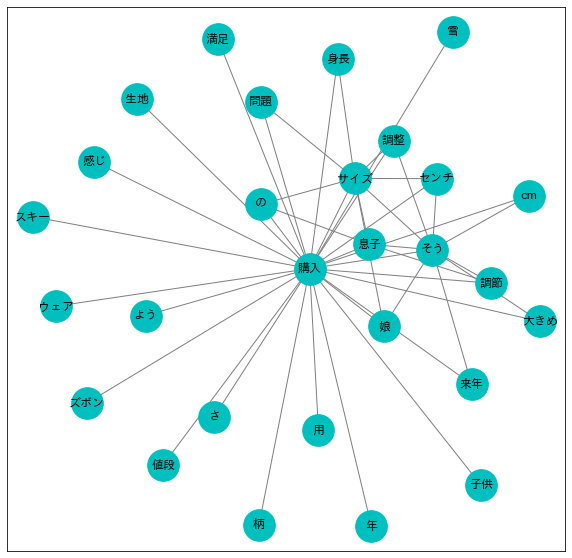

In [136]:
make_network(list_data = list_high, part_of_speech = "名詞", size = 50)

### 5.2. 関数の中身

`make_network()`関数の中身をブロックごとにみていくセクションです。それぞれのオブジェクトの中にどういった要素が含まれているのかに興味がある人は動かしてみてください。

In [137]:
list_high = df_high[0].values.tolist()

In [138]:
output = []

for sentence in list_high:
    t = Tokenizer()
    text = sentence
    result = t.tokenize(text)
    
    words = []
    
    for token in result:
        pos = token.part_of_speech.split(',')[0]
        if pos == '名詞':
            words.append(token.base_form)
    
    output.append(words)

In [139]:
# 文単位の名詞ペアリストを生成
pair_list = [
             list(itertools.combinations(n, 2))
             for n in output if len(output) >=2
             ]

# 名詞ペアリストの平坦化
all_pairs = []
for u in pair_list:
    all_pairs.extend(u)

# 名詞ペアの頻度をカウント
cnt_pairs = Counter(all_pairs)

In [140]:
cnt_pairs

Counter({('年', '息子'): 13,
         ('年', '用'): 6,
         ('年', '購入'): 29,
         ('年', '(^^)'): 4,
         ('年', '普段'): 7,
         ('年', '調節'): 15,
         ('年', '可能'): 2,
         ('年', '商品'): 15,
         ('年', '日'): 3,
         ('年', '店'): 4,
         ('年', '対応'): 1,
         ('年', '満足'): 7,
         ('息子', '用'): 15,
         ('息子', '購入'): 90,
         ('息子', '(^^)'): 5,
         ('息子', '普段'): 5,
         ('息子', '調節'): 38,
         ('息子', '可能'): 4,
         ('息子', '商品'): 16,
         ('息子', '日'): 6,
         ('息子', '店'): 11,
         ('息子', '対応'): 2,
         ('息子', '満足'): 15,
         ('用', '購入'): 71,
         ('用', '(^^)'): 6,
         ('用', '普段'): 2,
         ('用', '調節'): 8,
         ('用', '可能'): 3,
         ('用', '商品'): 8,
         ('用', '日'): 3,
         ('用', '店'): 5,
         ('用', '対応'): 1,
         ('用', '満足'): 14,
         ('購入', '(^^)'): 10,
         ('購入', '普段'): 18,
         ('購入', '購入'): 102,
         ('購入', '調節'): 60,
         ('購入', '可能'): 8,
         ('購入', '

In [147]:
tops = sorted(
    cnt_pairs.items(), 
    key=lambda x: x[1], reverse=True
    )[:50]
tops

[(('購入', 'そう'), 131),
 (('購入', '購入'), 102),
 (('購入', 'サイズ'), 98),
 (('購入', 'の'), 94),
 (('サイズ', 'そう'), 92),
 (('息子', '購入'), 90),
 (('センチ', '購入'), 88),
 (('娘', '購入'), 84),
 (('購入', '調整'), 82),
 (('サイズ', '調整'), 81),
 (('サイズ', '購入'), 75),
 (('用', '購入'), 71),
 (('サイズ', 'サイズ'), 62),
 (('購入', '調節'), 60),
 (('cm', '購入'), 58),
 (('購入', 'さ'), 57),
 (('購入', 'よう'), 56),
 (('センチ', 'サイズ'), 55),
 (('身長', '購入'), 54),
 (('センチ', 'そう'), 53),
 (('購入', '問題'), 53),
 (('購入', '来年'), 53),
 (('購入', '満足'), 52),
 (('購入', '大きめ'), 52),
 (('子供', '購入'), 50),
 (('息子', 'そう'), 50),
 (('購入', '値段'), 49),
 (('調整', 'そう'), 48),
 (('サイズ', 'の'), 47),
 (('購入', '生地'), 46),
 (('娘', 'そう'), 45),
 (('息子', 'の'), 44),
 (('身長', 'サイズ'), 44),
 (('購入', 'ズボン'), 44),
 (('来年', 'そう'), 42),
 (('調節', 'そう'), 41),
 (('購入', '柄'), 41),
 (('購入', 'ウェア'), 41),
 (('購入', '感じ'), 40),
 (('購入', '年'), 40),
 (('の', 'の'), 39),
 (('購入', '雪'), 39),
 (('サイズ', '問題'), 39),
 (('購入', '子供'), 39),
 (('息子', '調節'), 38),
 (('大きめ', 'そう'), 38),
 (('cm', 'そう'), 37),
 (('娘'

In [142]:
noun_1 = []
noun_2 = []
frequency = []

# データフレームの作成
for n,f in tops:
    noun_1.append(n[0])    
    noun_2.append(n[1])
    frequency.append(f)

df = pd.DataFrame({'前出名詞': noun_1, '後出名詞': noun_2, '出現頻度': frequency})

# 重み付きデータの設定
weighted_edges = np.array(df)

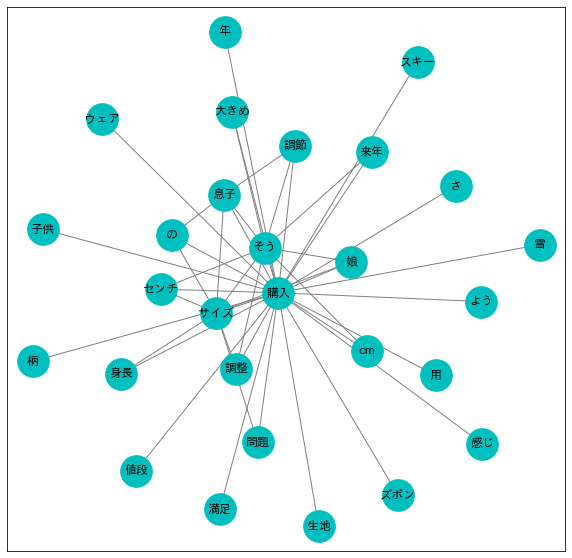

In [143]:
# グラフオブジェクトの生成
G = nx.Graph()

# 重み付きデータの読み込み
G.add_weighted_edges_from(weighted_edges)

# ネットワーク図の描画
plt.figure(figsize=(10,10))
nx.draw_networkx(G,
                 node_color = "c", 
                 node_size = 1000,
                 edge_color = "gray", 
                 font_family = "IPAexGothic") # フォント指定

plt.show()

### 5.3. データを絞る

いくつか単語を除いてみて、実装してみます。word cloudでいうstop wordです。テキストマイニングは、このようにデータをどこまで前処理するかが肝みたいです。

In [144]:
# 「購入」を抜く
df_high[0] = df_high[0].str.replace('購入', '')
df_high.head()

,0,flag
1699,年の息子用にしました(^^)普段ですがを！ちょっと大きいけど調節可能なので全然着れます(^^...,0
1579,値段も安いしどうなのかな？と思っていましたが充分です。まだ行くのは先ですが子供に着させるのが...,0
21,〜センチの歳息子にを、大丈夫かなーとおもったらブッカブカでした（笑）小学校くらいでちょうどい...,0
1659,サイズはセンチをしました！デザインも可愛く、縫製もしっかりしていて満足しています。ウエストや...,1
248,cm弱の娘にｃｍピンクを。雪山デビューで雪遊びのみの利用で。第一印象は、カッコカワイイです。...,1


In [148]:
# 複数の文字列を一気に抜きたいときはこう。正規表現を使っています。
df_high[0] = df_high[0].str.replace('センチ|cm', '', regex=True)
df_high.head()

,0,flag
1699,年の息子用にしました(^^)普段ですがを！ちょっと大きいけど調節可能なので全然着れます(^^...,0
1579,値段も安いしどうなのかな？と思っていましたが充分です。まだ行くのは先ですが子供に着させるのが...,0
21,〜の歳息子にを、大丈夫かなーとおもったらブッカブカでした（笑）小学校くらいでちょうどいいかな...,0
1659,サイズはをしました！デザインも可愛く、縫製もしっかりしていて満足しています。ウエストや丈の調...,1
248,弱の娘にｃｍピンクを。雪山デビューで雪遊びのみの利用で。第一印象は、カッコカワイイです。大き...,1


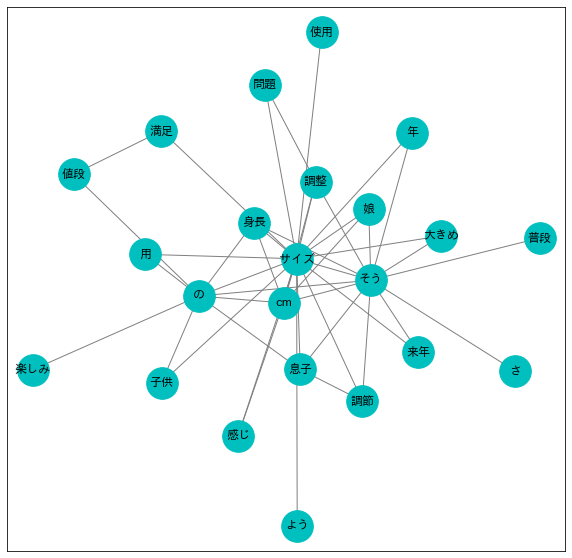

In [146]:
# 実装
list_high = df_high[0].values.tolist()
make_network(list_high, "名詞", size = 50)